# 0. Import Libraries

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', None)

import itertools

!pip install pyxlsb
import pyxlsb

import matplotlib.pyplot as plt 

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf, acf

!pip install pmdarima
import pmdarima as pm

from sentence_transformers import SentenceTransformer, util

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.6 MB/s eta 0:00:0000:010:01


2025-08-13 13:40:20.066380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755092420.406642      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755092420.502384      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Task 1: Data Analysis Task

## 1.1 Read data

In [2]:
dataframe1 = pd.read_csv("/kaggle/input/stc-jawwy-dataset/stc TV Data Set_T1.csv")
df1=dataframe1.copy()

## 1.2 Check data shape

In [3]:
df1.shape

(1048575, 13)

## 1.3 Display the first 5 rows

In [4]:
df1.head()

,Column1,date_,user_id_maped,program_name,duration_seconds,program_class,season,episode,program_desc,program_genre,series_title,hd,original_name
0,1,42882,26138,100 treets,40,MOVIE,0,0,Drama Movie100 Streets,Drama,0,0,100 treets
1,3,42876,7946,Moana,17,MOVIE,0,0,Animation MovieMoana (HD),Animation,0,1,Moana
2,4,42957,7418,The Mermaid Princess,8,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
3,5,42942,19307,The Mermaid Princess,76,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
4,7,42923,15860,Churchill,87,MOVIE,0,0,Biography MovieChurchill (HD),Biography,0,1,Churchill


## 1.4 Data preprocessing on the input data

In [5]:
df1 = df1.drop(columns=['Column1'])         # dropping the index column
df1['program_name'] = df1['program_name'].str.strip()  # trim spaces in movies names to avoid misspellings in input data
df1['date_'] = pd.to_datetime(df1['date_'], unit='D', origin='30/12/1899')  # read date column as date data type
df1[['duration_seconds', 'season','episode','series_title','hd']] = df1[['duration_seconds', 'season','episode','series_title','hd']].apply(pd.to_numeric)  # read numeric columns as numeric data types
df1[['user_id_maped', 'program_name','program_class','program_desc','program_genre','original_name']] = df1[['user_id_maped', 'program_name','program_class','program_desc','program_genre','original_name']].astype(str) # read string columns as string data types
df1.head()

,date_,user_id_maped,program_name,duration_seconds,program_class,season,episode,program_desc,program_genre,series_title,hd,original_name
0,2017-05-27,26138,100 treets,40,MOVIE,0,0,Drama Movie100 Streets,Drama,0,0,100 treets
1,2017-05-21,7946,Moana,17,MOVIE,0,0,Animation MovieMoana (HD),Animation,0,1,Moana
2,2017-08-10,7418,The Mermaid Princess,8,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
3,2017-07-26,19307,The Mermaid Princess,76,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
4,2017-07-07,15860,Churchill,87,MOVIE,0,0,Biography MovieChurchill (HD),Biography,0,1,Churchill


## 1.5 Display the dataset after applying data types


In [6]:
df1.head()

,date_,user_id_maped,program_name,duration_seconds,program_class,season,episode,program_desc,program_genre,series_title,hd,original_name
0,2017-05-27,26138,100 treets,40,MOVIE,0,0,Drama Movie100 Streets,Drama,0,0,100 treets
1,2017-05-21,7946,Moana,17,MOVIE,0,0,Animation MovieMoana (HD),Animation,0,1,Moana
2,2017-08-10,7418,The Mermaid Princess,8,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
3,2017-07-26,19307,The Mermaid Princess,76,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
4,2017-07-07,15860,Churchill,87,MOVIE,0,0,Biography MovieChurchill (HD),Biography,0,1,Churchill


## 1.6 Describe the numeric values in the dataset

In [7]:
df1.describe()

,date_,duration_seconds,season,episode,series_title,hd
count,1048575,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,2017-10-04 00:23:20.346184192,1.230957e+03,1.342139e+00,6.157952e+00,1.205922e-02,3.862728e-01
min,2017-03-14 00:00:00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2017-06-10 00:00:00,5.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2017-10-14 00:00:00,1.190000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,2018-01-21 00:00:00,1.328000e+03,1.000000e+00,9.000000e+00,0.000000e+00,1.000000e+00
max,2018-04-30 00:00:00,1.461329e+06,2.300000e+01,2.820000e+02,1.000000e+00,1.000000e+00
std,NaN,6.821058e+03,2.104095e+00,1.222015e+01,1.091504e-01,4.868946e-01


## 1.7 Check if any column has null value in the dataset

In [8]:
df1.isnull().any()

date_               False
user_id_maped       False
program_name        False
duration_seconds    False
program_class       False
season              False
episode             False
program_desc        False
program_genre       False
series_title        False
hd                  False
original_name       False
dtype: bool

## 1.8 Get the most watched movies (Total Views / Total Users Views / Total watch time)
For series we concatenated the Session episode to differentiate between episodes

In [9]:
grouped=df1.copy()
grouped.loc[grouped['program_class'] == 'SERIES/EPISODES', 'program_name'] = grouped['program_name']+'_SE'+grouped['season'].astype(str)+'_EP'+grouped['episode'].astype(str)
grouped = grouped.groupby(['program_name','program_class'])\
.agg({'user_id_maped': [('co1', 'nunique'),('co2', 'count')],\
      'duration_seconds': [('co3', 'sum')] }).reset_index()
grouped.columns = ['program_name','program_class','No of Users who Watched', 'No of watches', 'Total watch time in seconds']
grouped['Total watch time in houres']=grouped['Total watch time in seconds']/3600
grouped = grouped.drop(columns=['Total watch time in seconds'])
grouped = grouped.sort_values(by=['Total watch time in houres', 'No of watches','No of Users who Watched'], ascending=False).reset_index(drop=True)


## 1.9 Top 10 programs in total watch time in hours

In [10]:
fig = px.pie(grouped.head(10), values='Total watch time in houres', names='program_name',\
             hover_data=['program_class'],title='top 10 programs in total watch time in houres')
fig.show()

## 1.10 Study the customer experience against Program class

In [11]:
grouped=df1.copy()
grouped = grouped.groupby('program_class')\
.agg({'user_id_maped': [('co1', 'nunique'),('co2', 'count')],\
      'duration_seconds': [('co3', 'sum')] }).reset_index()
grouped.columns = ['program_class','No of Users who Watched', 'No of watches', 'Total watch time in seconds']
grouped['Total watch time in houres']=grouped['Total watch time in seconds']/3600
grouped = grouped.drop(columns=['Total watch time in seconds'])
grouped = grouped.sort_values(by=['Total watch time in houres', 'No of watches','No of Users who Watched'], ascending=False).reset_index(drop=True)

### 1.11 Total duration spent by program_class

In [12]:
fig = px.pie(grouped, values='Total watch time in houres', names='program_class',\
             hover_data=['program_class'],title='Total duration spent by program_class')
fig.update_traces()
fig.show()

### 1.12 Total duration spent by program_class

In [13]:
fig2 = px.pie(grouped, values='No of Users who Watched', names='program_class',\
             hover_data=['program_class'],title='Total Users watching by program_class')
fig2.update_traces()
fig2.show()

## 1.13 TODO Study the relation and user's behaviour Against HD flag

### 1.13.1 Feature engineering

In [14]:
task1_solution = df1.copy()
task1_solution = task1_solution.groupby(['hd', 'program_class']).agg({
    'user_id_maped': [('No of Users who Watched', 'nunique'), ('No of watches', 'count')],
    'duration_seconds': [('Total watch time in seconds', 'sum')]
}).reset_index()
task1_solution.columns = ['hd','program_class','No of Users who Watched', 'No of watches', 'Total watch time in seconds']
task1_solution['Total watch time in houres']=task1_solution['Total watch time in seconds']/3600
task1_solution = task1_solution.drop(columns=['Total watch time in seconds'])
task1_solution = task1_solution.sort_values(by=['Total watch time in houres', 'No of watches','No of Users who Watched'], ascending=False).reset_index(drop=True)
task1_solution.head()

,hd,program_class,No of Users who Watched,No of watches,Total watch time in houres
0,0,SERIES/EPISODES,3282,486884,229776.593333
1,1,MOVIE,10880,331746,64856.366111
2,0,MOVIE,6093,156655,38587.779444
3,1,SERIES/EPISODES,2625,73290,25321.194167


### 1.13.2 Users who watch HD V.S. SD

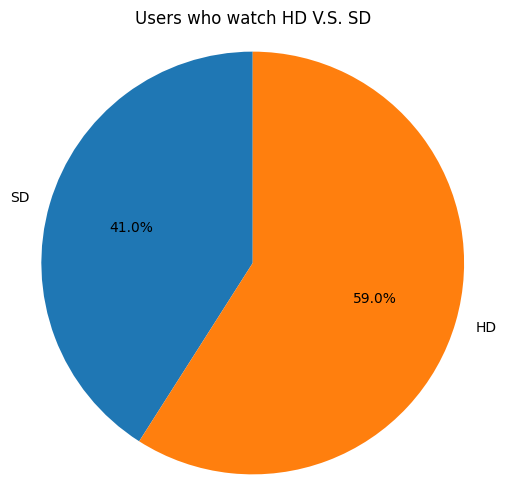

In [15]:
users_by_quality = task1_solution.groupby('hd')['No of Users who Watched'].sum()
labels = ['SD', 'HD']
plt.figure(figsize=(6,6))
plt.pie(users_by_quality, labels=['SD', 'HD'], autopct='%1.1f%%', startangle=90)
plt.title('Users who watch HD V.S. SD')
plt.axis('equal')
plt.show()

# 2. Task 2: Forecasting Task

## 2.1 Read data

In [16]:
df2 = pd.read_excel("/kaggle/input/stc-jawwy-dataset/stc TV Data Set_T2 .xlsx",index_col=0)

## 2.2 Check data shape

In [17]:
df2.describe()

,date_,Total_watch_time_in_houres
count,86,86.000000
mean,2018-02-28 17:01:23.720930304,780.817926
min,2018-01-01 00:00:00,562.124722
25%,2018-01-30 06:00:00,707.709653
50%,2018-02-28 12:00:00,763.181389
75%,2018-03-29 18:00:00,840.985278
max,2018-04-30 00:00:00,1123.551944
std,NaN,122.992002


## 2.3 Display the first 5 rows

In [18]:
df2.head()

,date_,Total_watch_time_in_houres
0,2018-01-01,1123.551944
1,2018-01-02,1000.129722
2,2018-01-03,881.924444
3,2018-01-04,782.669444
4,2018-01-05,1051.939444


## 2.4 Describe the numeric values in the dataset

In [19]:
df2.describe()

,date_,Total_watch_time_in_houres
count,86,86.000000
mean,2018-02-28 17:01:23.720930304,780.817926
min,2018-01-01 00:00:00,562.124722
25%,2018-01-30 06:00:00,707.709653
50%,2018-02-28 12:00:00,763.181389
75%,2018-03-29 18:00:00,840.985278
max,2018-04-30 00:00:00,1123.551944
std,NaN,122.992002


## 2.5 Check if any column has null value in the dataset

In [20]:
df2.isnull().any()

date_                         False
Total_watch_time_in_houres    False
dtype: bool

## 2.6 Setting the date as index


In [21]:
df2.set_index('date_', inplace=True)

## 2.7 Display the dataframe after setting the date as index

In [22]:
df2.head()

,Total_watch_time_in_houres
date_,
2018-01-01,1123.551944
2018-01-02,1000.129722
2018-01-03,881.924444
2018-01-04,782.669444
2018-01-05,1051.939444


## 2.8 show the dataframe

In [23]:
fig = px.line(df2,  y="Total_watch_time_in_houres")
fig.show()

In [24]:
df2.index = pd.DatetimeIndex(df2.index)
df2 = df2.asfreq('B')

## 2.9 TODO build a prediction model to predict the expected watch time for the next two months


### 2.9.1 Decomposing Watch Time

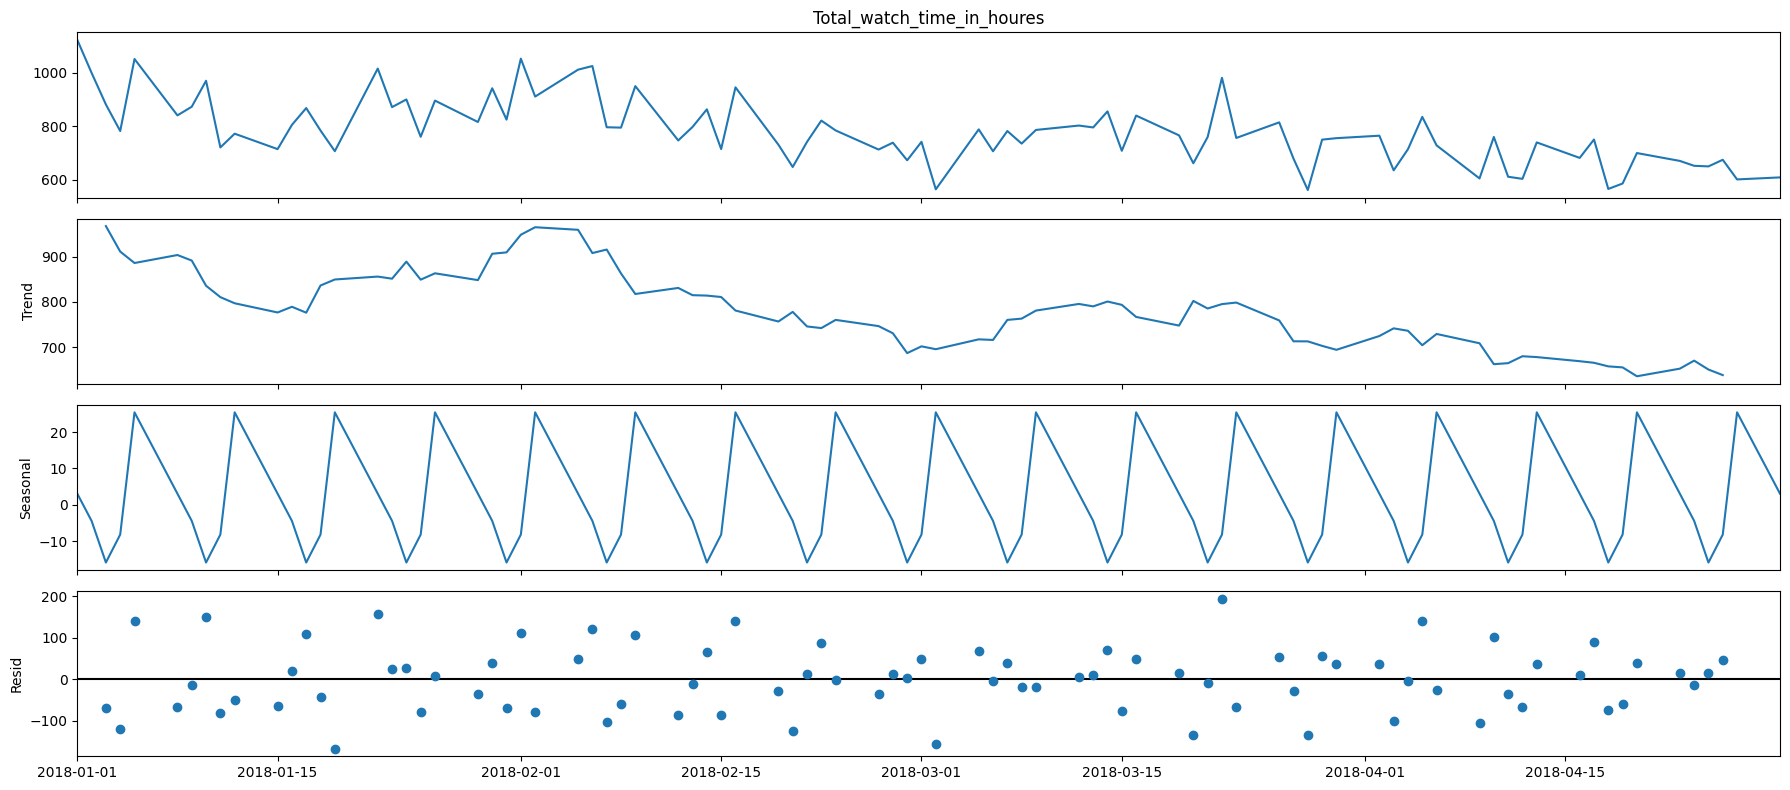

In [25]:
y = df2["Total_watch_time_in_houres"]
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### 2.9.2 Generate Parameters

In [26]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### 2.9.3 Brute Force the Model

In [27]:
best_aic = float("inf")
best_param = None
best_seasonal_param = None
best_results = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                y,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=True,
                enforce_invertibility=False
            )
            results = mod.fit(disp=0)
            print(f"ARIMA{param}x{param_seasonal}12 - AIC: {results.aic}")

            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = param_seasonal
                best_results = results

        except:
            continue

print("\nBest model found:")
print(f"ARIMA{best_param}x{best_seasonal_param}12 - AIC: {best_aic}")

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC: 1393.7197896122402
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC: 1322.6450083081868
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC: 958.3625156123754
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC: 942.0657659770475
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC: 1153.5843936632664
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC: 1138.4941534628726
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC: 939.293356497526
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC: 940.9345100719539
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC: 1303.318311313008
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC: 1267.0776958049469
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC: 959.4316765909733
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC: 940.185170396154
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC: 1151.2466899167273
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC: 1131.2434551330073
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC: 937.8802530909375
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC: 939.0125465397228
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC: 1065.2447995635102
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC: 1061

### 2.9.4 Train the Model

In [28]:
mod = sm.tsa.statespace.SARIMAX(
    y,
    order=best_param,
    seasonal_order=best_seasonal_param,
    enforce_stationarity=True,
    enforce_invertibility=False
)
best_results = mod.fit(disp=0)

# Show summary
print(best_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8312      0.097     -8.606      0.000      -1.020      -0.642
ar.S.L12      -0.2321      0.154     -1.502      0.133      -0.535       0.071
ma.S.L12      -1.0000      0.186     -5.372      0.000      -1.365      -0.635
sigma2      8975.0337   2.07e-05   4.33e+08      0.000    8975.034    8975.034


### 2.9.5 Plot Results

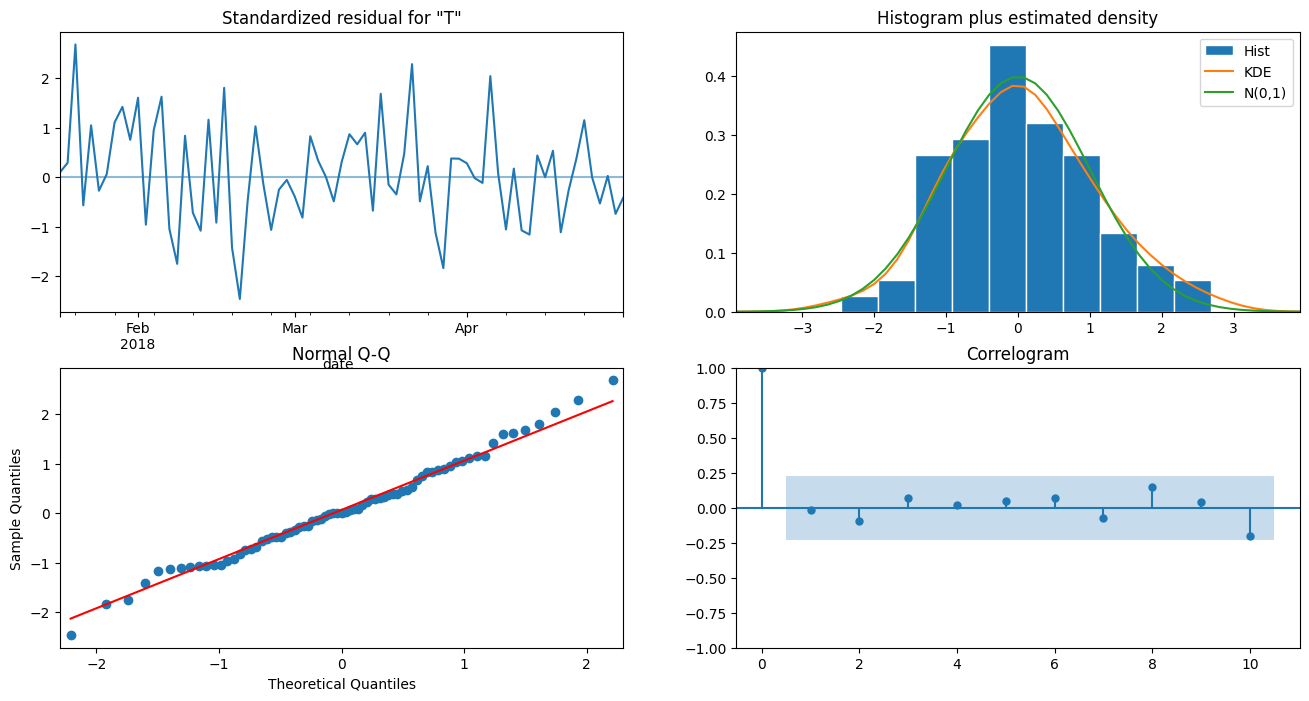

In [29]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### 2.9.6 Forecast the actual data

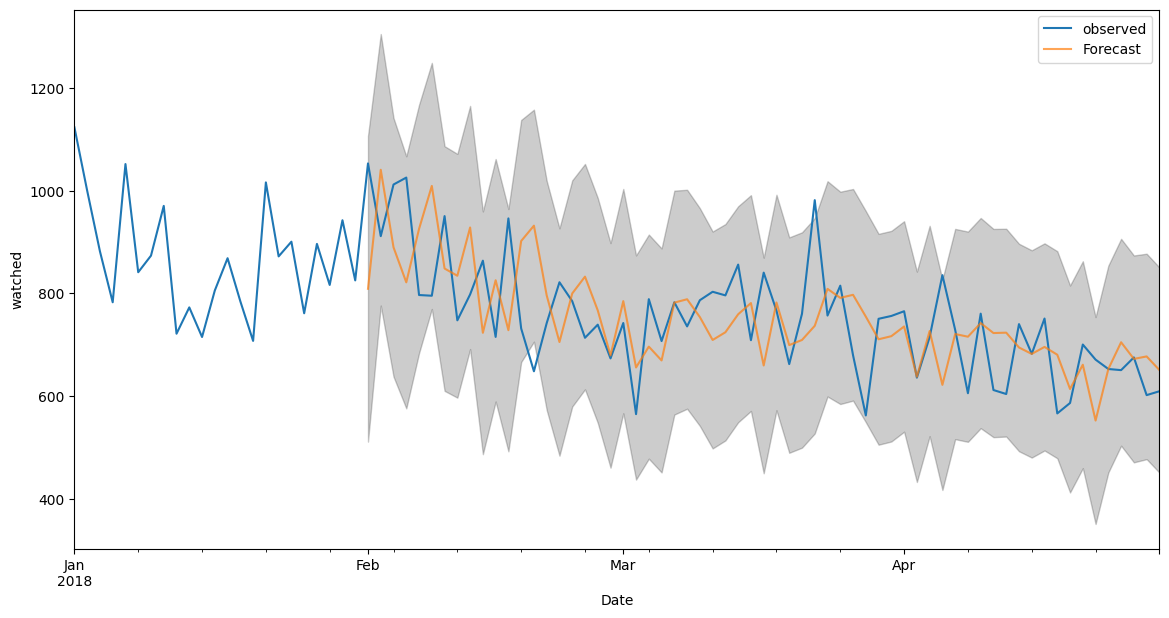

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2018-02-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df2['Total_watch_time_in_houres'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('watched')
plt.legend()
plt.show()

### 2.9.7 Forecast the next 2 months

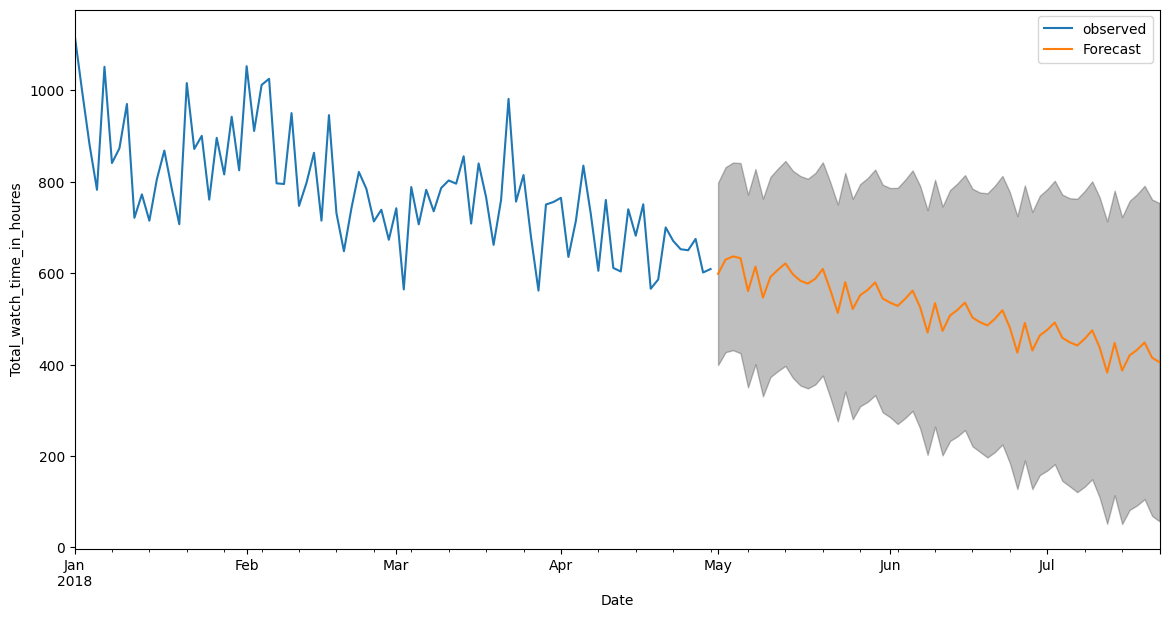

In [31]:
forecast = results.get_forecast(steps=60)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = df2['Total_watch_time_in_houres'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Total_watch_time_in_houres')
plt.legend()
plt.show()

# Task 3: Recommendation Systems Task

# 3.1 Read data

In [32]:
df3 = pd.read_excel("/kaggle/input/stc-jawwy-dataset/stc TV Data Set_T3.xlsb", index_col=0)
df_movies = pd.read_csv('/kaggle/input/top-500-600-movies-of-each-year-from-1960-to-2024/final_dataset.csv')

# 3.2 Check data shape

In [33]:
print("data shape", df3.shape)
print("df_movies data shape", df_movies.shape)

data shape (1048575, 5)
df_movies data shape (63249, 24)


# 3.3 Describe the numeric values in the dataset

In [34]:
df3.describe()

,user_id_maped,rating,date_
count,1.048575e+06,1.048575e+06,1048575
mean,1.709266e+04,2.497283e+00,2017-10-04 00:23:20.346184192
min,1.000000e+00,1.000000e+00,2017-03-14 00:00:00
25%,8.253000e+03,1.000000e+00,2017-06-10 00:00:00
50%,1.714900e+04,2.000000e+00,2017-10-14 00:00:00
75%,2.566500e+04,3.000000e+00,2018-01-21 00:00:00
max,3.428000e+04,4.000000e+00,2018-04-30 00:00:00
std,1.003513e+04,1.119837e+00,NaN


# 3.4 Check if any column has null value in the dataset

In [35]:
df3.isnull().any()

user_id_maped    False
program_name     False
rating           False
date_            False
program_genre    False
dtype: bool

# 3.5 Data review

In [36]:
df3.head()

,user_id_maped,program_name,rating,date_,program_genre
0,26138,100 treets,1,2017-05-27,Drama
1,7946,Moana,1,2017-05-21,Animation
2,7418,The Mermaid Princess,1,2017-08-10,Animation
3,19307,The Mermaid Princess,2,2017-07-26,Animation
4,15860,Churchill,2,2017-07-07,Biography


In [37]:
df_movies.rename(columns={'title': 'program_name'}, inplace=True)
df_movies[['program_name','description']].head()

,program_name,description
0,Jaws,When a massive killer shark unleashes chaos on...
1,The Rocky Horror Picture Show,A newly-engaged couple have a breakdown in an ...
2,One Flew Over the Cuckoo's Nest,"In the Fall of 1963, a Korean War veteran and ..."
3,Dog Day Afternoon,Three amateur robbers plan to hold up a Brookl...
4,Shampoo,"On Election Day, 1968, irresponsible hairdress..."


In [38]:
merged_df = pd.merge(df3, df_movies[['program_name', 'description']], on='program_name')
merged_df.head()

,user_id_maped,program_name,rating,date_,program_genre,description
0,7946,Moana,1,2017-05-21,Animation,Live-action adaptation of the 2016 Disney anim...
1,7946,Moana,1,2017-05-21,Animation,"In ancient Polynesia, when a terrible curse in..."
2,7946,Moana,1,2017-05-21,Animation,Filmmaker Robert J. Flaherty presents a docufi...
3,15860,Churchill,2,2017-07-07,Biography,Ninety-six hours before the World War II invas...
4,6358,Coco,1,2018-03-29,Animation,"Aspiring musician Miguel, confronted with his ..."


In [39]:
df_movies.columns

Index(['id', 'program_name', 'year', 'duration', 'MPA', 'rating', 'votes',
       'meta_score', 'description', 'Movie_Link', 'writers', 'directors',
       'stars', 'budget', 'opening_weekend_gross', 'gross_worldwide',
       'gross_us_canada', 'release_date', 'countries_origin',
       'filming_locations', 'production_companies', 'awards_content', 'genres',
       'languages'],
      dtype='object')

# 3.6  TODO build a Recommender system to Highlight Programs that usesrs might be interested in

# 3.6 Preference-Based Recommender System

## 3.6.1 data preparation

In [40]:
df_movies.rename(columns={'title': 'program_name'}, inplace=True)
pbrc_df = pd.merge(df3, df_movies[['program_name', 'year']], on='program_name')
pbrc_df = pbrc_df.drop_duplicates(subset=['program_name'])
pbrc_df = pbrc_df.dropna(subset=['program_name', 'program_genre', 'year', 'rating'])
pbrc_df['program_name'] = pbrc_df['program_name'].astype(str).str.lower()
pbrc_df['program_genre'] = pbrc_df['program_genre'].astype(str).str.lower()
pbrc_df.head()

,user_id_maped,program_name,rating,date_,program_genre,year
0,7946,moana,1,2017-05-21,animation,2025
3,15860,churchill,2,2017-07-07,biography,2017
4,6358,coco,1,2018-03-29,animation,2017
5,11660,kidnap,2,2018-01-27,action,2017
6,5155,the accountant,1,2017-03-30,action,2016


## 3.6.2 Take preference input from the user

In [41]:
program_name = input("enter program name: ").strip().lower()
rating = input("enter rating: ").strip()
year = input("enter year: ").strip()
program_genre = input("enter genre: ").strip().lower()

enter program name:  spiderman
enter rating:  6
enter year:  2022
enter genre:  action


## 3.6.3 Sort the input for tfidf

In [42]:
user_text = f"{program_name} {rating} {year} {program_genre}"
pbrc_df['combined'] = pbrc_df['program_name'] + ' ' + pbrc_df['rating'].astype(str) + ' ' + pbrc_df['year'].astype(str) + ' ' + pbrc_df['program_genre']

## 3.6.4 Term frequency inverse document frequency (TFIDF)

In [43]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(pbrc_df['combined'].tolist() + [user_text])
cos_sim = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])[0]

## 3.6.5 Apply cosine similarity

In [44]:
pbrc_df['similarity'] = cos_sim
top_matches = pbrc_df.sort_values(by='similarity', ascending=False).head(10).reset_index(drop=True)
top_matches[['program_name', 'rating', 'year', 'program_genre', 'similarity']]

,program_name,rating,year,program_genre,similarity
0,final cut,1,2022,drama,0.366040
1,cheaper by the dozen,1,2022,comedy,0.297563
2,2012,4,2009,action,0.081933
3,x-men,1,2000,action,0.067246
4,transformers,1,2007,action,0.064065
5,machete,3,2010,action,0.061265
6,zoo,1,2007,action,0.060819
7,300,2,2006,action,0.060306
8,maleficent,2,2014,action,0.059215
9,pompeii,1,2014,action,0.059215


# 3.7  TODO show the recommendations (top 5) for the people who watched "Moana" movie

## 3.7.1 Read data

In [45]:
df_movies = pd.read_csv('/kaggle/input/top-500-600-movies-of-each-year-from-1960-to-2024/final_dataset.csv')

## 3.7.2 Data preparation

In [46]:
df_movies['title'] = df_movies['title'].str.lower().str.strip()
df_movies['description'] = df_movies['description'].fillna('')

## 3.7.3 Model inputs

In [47]:
movie_title = "Moana".lower().strip()
top_n = 5

## 3.7.4 Load model

In [48]:
model = SentenceTransformer('all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## 3.7.5 Model embedding

In [49]:
embeddings = model.encode(df_movies['description'].tolist(), batch_size=64, show_progress_bar=True, convert_to_numpy=True)
embedding_matrix = np.stack(embeddings)

Batches:   0%|          | 0/989 [00:00<?, ?it/s]

## 3.7.6 Apply model

In [50]:
matched = df_movies[df_movies['title'] == movie_title]

if matched.empty:
    print(f"move '{movie_title}' doesnt exist")
    recommendations = pd.DataFrame()
else:
    idx = matched.index[0]
    input_embedding = embedding_matrix[idx].reshape(1, -1)

    sim_scores = cosine_similarity(input_embedding, embedding_matrix)[0]

    top_indices = np.argsort(sim_scores)[::-1]
    top_indices = top_indices[top_indices != idx][:top_n]

    recommendations = df_movies.iloc[top_indices][['title', 'description']]
    recommendations['similarity'] = sim_scores[top_indices]

## 3.7.7 Result

In [51]:
recommendations

,title,description,similarity
10203,moana 2,After receiving an unexpected call from her wa...,0.590290
25578,der struwwelpeter,A live action adaptation of the 1845 children'...,0.566431
22087,frozen reo maori,"The Maori dub of the iconic Disney movie, Froz...",0.562835
7080,hermelinda linda,Live action feature based on the Mexican comic...,0.557790
42220,"life, animated",A coming-of-age story about a boy and his fami...,0.556348
